In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rampy as rp
import os

# Arquivo: `Denezine_MP3710_Aj.txt` 

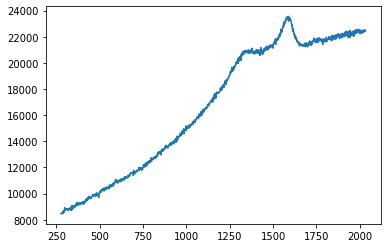

In [4]:
file = 'Denezine_MP3710_Aj.txt'
R = pd.read_csv('../raman_dados/'+file,header = None, sep = '\t')
R = R.values

plt.plot(R[:,0],R[:,1])


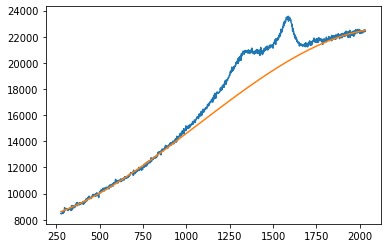

In [92]:
roi = np.array([[260,900],[1900,2100]])
x, y = R[:,0], R[:,1]

# calculating the baselines
ycalc_poly, base_poly = rp.baseline(x,y,roi,'poly',polynomial_order=3 )
plt.plot(x,y,x,base_poly)


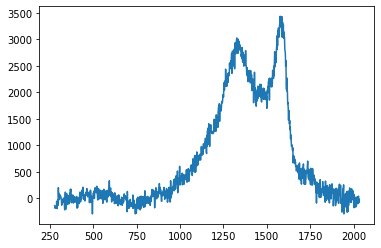

In [93]:
plt.plot(x,ycalc_poly)


In [94]:
import lmfit
from lmfit.models import GaussianModel

In [95]:
inputsp = R
y_corr = ycalc_poly
# signal selection
lb = 260 # The lower boundary of interest
hb = 2000 # The upper boundary of interest
x = inputsp[:,0]
x_fit = x[np.where((x > lb)&(x < hb))]
y_fit = y_corr[np.where((x > lb)&(x < hb))]
ese0 = np.sqrt(abs(y_fit[:,0]))/abs(y_fit[:,0]) # the relative errors after baseline subtraction
YM = np.amax(y_fit[:,0])*10
y_fit[:,0] = y_fit[:,0]/YM # normalise spectra to maximum intensity, easier to handle 
sigma = abs(ese0*y_fit[:,0]) #calculate good ese

In [175]:
def residual(pars, x, data=None, eps=None): #Function definition
    # unpack parameters, extract .value attribute for each parameter
    n = len(pars)//3

    la = ['a'+str(i) for i in range(1,n+1)]
    lf = ['f'+str(i) for i in range(1,n+1)]
    ll = ['l'+str(i) for i in range(1,n+1)]
    
    a = [pars[i].value for i in la]
    f = [pars[i].value for i in lf]
    l = [pars[i].value for i in ll]
    
    # Using the Gaussian model function from rampy
    peaks = [rp.gaussian(x,a[i],f[i],l[i]) for i in range(n)]

    model = np.zeros(peaks[0].shape)
    for p in peaks:
        model += p
    
    if data is None: # if we don't have data, the function only returns the direct calculation
        return model, peaks
    if eps is None: # without errors, no ponderation
        return (model - data)
    return (model - data)/eps # with errors, the difference is ponderated

Text(0.5, 0, 'Raman shift, cm$^{-1}$')

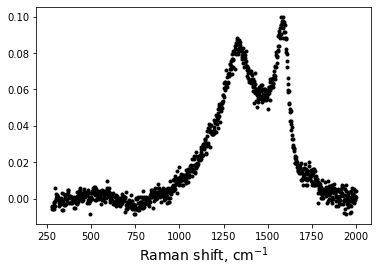

In [176]:
plt.plot(x_fit,y_fit,'k.')
plt.xlabel("Raman shift, cm$^{-1}$", fontsize = 14)

In [177]:
params = lmfit.Parameters()
#               (Name,  Value,  Vary,   Min,  Max,  Expr)
params.add_many(('a1',   2.4,   True,  0,      None,  None),
                ('f1',   500,   True, 400,    700,  None),
                ('l1',   26,   True,  0,      None,  None),
                ('a2',   3.5,   True,  0,      None,  None),
                ('f2',   1250,  True, 100,   1500,  None),
                ('l2',   39,   True,  0,   None,  None),  
                ('a3',   8.5,    True,    0,      None,  None),
                ('f3',   1600,  True, 1500,   1700,  None),
                ('l3',   31,   True,  0,   None,  None))

In [178]:
len(params)//3

3

In [179]:
n = len(params)//3
lf = ['f'+str(i) for i in range(1,n+1)]
for i in lf:
    params[i].vary = False

algo = 'nelder'  
    
result = lmfit.minimize(residual, params, method = algo, args=(x_fit, y_fit[:,0])) # fit data with  nelder model from scipy

In [183]:

# we release the positions but contrain the FWMH and amplitude of all peaks 
n = len(params)//3
lf = ['f'+str(i) for i in range(1,n+1)]
for i in lf:
    params[i].vary = True

result2 = lmfit.minimize(residual, params,method = algo, args=(x_fit, y_fit[:,0])) # fit data with leastsq model from scipy

In [186]:
model = lmfit.fit_report(result2.params)
yout, peaks = residual(result2.params,x_fit) # the different peaks
rchi2 = (1/(float(len(y_fit))-15-1))*np.sum((y_fit - yout)**2/sigma**2) # calculation of the reduced chi-square
print(model)

rchi-2 = 
72038297.75818816


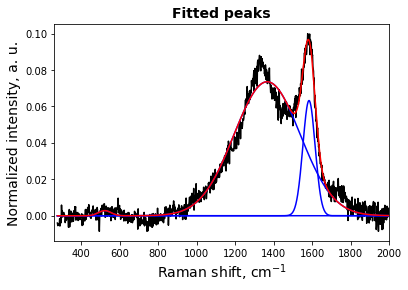

In [189]:
##### WE DO A NICE FIGURE THAT CAN BE IMPROVED FOR PUBLICATION
plt.plot(x_fit,y_fit,'k-')
for p in peaks:
    plt.plot(x_fit,p,'b-')
plt.plot(x_fit,yout,'r-')
    
plt.xlim(lb,hb)
#plt.ylim(-0.5,10.5)
plt.xlabel("Raman shift, cm$^{-1}$", fontsize = 14)
plt.ylabel("Normalized intensity, a. u.", fontsize = 14)
plt.title("Fitted peaks",fontsize = 14,fontweight = "bold")
print("rchi-2 = \n"+str(rchi2))